In [6]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
class FitnessLandscape:
    def __init__(self, Wsec, ndim, distance, bridgedepth):
        """
        Initialize the fitness landscape with the given secondary peak fitness.

        Arguments:
            Wsec (float): The fitness of the secondary peak.
            ndim: Dimensionality (number of dimensions of the search space)
            distance: Distance between the two peaks
            bridgedepth: Fitness at the bridge
        """
        self.Wsec = Wsec
        self.ndim = ndim
        self.distance = distance
        self.bridgedepth = bridgedepth
        self.peak1 = np.random.randint(0, 2, size=self.ndim) # Primary (taller) peak location, randomly generated
        self.peak2 = self.generate_hamming_neighbor(self.peak1, self.distance)  # Secondary peak location, narrower/flatter
        self.random_differing_indices = np.random.choice(np.where(self.peak1 != self.peak2)[0],2, replace=False)
        self.bridge = self.peak1.copy()
        self.bridge[self.random_differing_indices] = 1- self.bridge[self.random_differing_indices]
        #self.bridge = self.generate_bridge()

    @staticmethod
    def hamming_distance(coord1, coord2):
        """
        Calculate the Hamming distance between two binary numpy arrays.

        Arguments:
            coord1: The first binary numpy array
            coord2: The second binary numpy array
        """
        return np.sum(coord1 != coord2)

    @staticmethod
    def generate_hamming_neighbor(binary_array, target_distance):
        """
        Generate a random binary array with some specified Hamming distance from the given binary array.

        Arguments:
            binary_array (numpy.ndarray): Input binary array.
            target_distance (int): Desired Hamming distance.

        Returns:
            numpy.ndarray: A randomly generated binary array with the specified Hamming distance.
        """
        assert 0 <= target_distance <= len(binary_array)

        new_array = binary_array.copy()
        indices_to_flip = np.random.choice(len(binary_array), size=target_distance, replace=False)
        new_array[indices_to_flip] = 1 - new_array[indices_to_flip]
        return new_array


    def compute_fitness(self, coordinates):
        """
        Compute the fitness of a genotype given a set of coordinates.

        Argumentss:
            coordinates (numpy.ndarray): Genotype/phenotype

        Returns:
            float: The fitness value.
        """
        assert coordinates.shape == (self.ndim,)

        # Fitness for primary peak
        if np.array_equal(coordinates, self.peak1):
            return 1.0

        # Fitness for primary peak neighborhood
        if self.hamming_distance(coordinates, self.peak1) == 1:
            return 0.5

        # Fitness for secondary peak
        if np.array_equal(coordinates, self.peak2):
            return self.Wsec
        
        if np.array_equal(coordinates, self.bridge):
            return self.bridgedepth

        # Fitness for secondary peak neighborhood
        dist_to_peak2 = self.hamming_distance(coordinates, self.peak2)
        if 1 <= dist_to_peak2 <= 4:
            return self.Wsec * (0.2 * (5 - dist_to_peak2))  # Linearly decreasing fitness

        # Default fitness for all other genotypes
        return 0.0


In [8]:
# Example usage
landscape = FitnessLandscape(Wsec=0.5, ndim = 30, distance = 7, bridgedepth= 0.7)
print("Peak 1: {}, \nPeak 2 : {}, \nBridge : {}".format(landscape.peak1, landscape.peak2, landscape.bridge))
print("Hamming distance between peak 1 and peak 2: {}".format(FitnessLandscape.hamming_distance(landscape.peak1,landscape.peak2)))
print("Hamming distance between peak 1 and bridge: {}".format(FitnessLandscape.hamming_distance(landscape.peak1,landscape.bridge)))
print("Hamming distance between peak 2 and bridge: {}".format(FitnessLandscape.hamming_distance(landscape.peak2,landscape.bridge)))

#print(FitnessLandscape.hamming_distance(landscape.peak1,landscape.bridge))
#print(FitnessLandscape.hamming_distance(landscape.peak2,landscape.bridge))
#print(landscape.compute_fitness(landscape.peak1))
#print(landscape.compute_fitness(landscape.peak2))
#print(landscape.compute_fitness(landscape.bridge))
#print(landscape.compute_fitness(np.array([0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,1])))


Peak 1: [1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1], 
Peak 2 : [1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1], 
Bridge : [1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1]
Hamming distance between peak 1 and peak 2: 7
Hamming distance between peak 1 and bridge: 2
Hamming distance between peak 2 and bridge: 5


In [9]:
# Genetic Algorithm Implementation
class GeneticAlgorithm:
    def __init__(self, fitness_landscape, pop_size, mutation_rate, meta_mutation_rate, generations, evolving_mutation):
        self.fitness_landscape = fitness_landscape
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.metamuration_rate = meta_mutation_rate
        self.generations = generations
        self.evolving_mutation = evolving_mutation
        self.population = self.initialize_population()

    def initialize_population(self):
        """
        Initialize the population with random binary genotypes.
        """
        #print(np.random.randint(0, 2, size=(self.pop_size, self.fitness_landscape.ndim)))
        #print(np.tile(self.fitness_landscape.peak1,(self.pop_size, 1)))
        return np.array([np.hstack((self.fitness_landscape.peak1, np.random.uniform(0,2*self.mutation_rate))) if np.random.rand() < 0.5 else np.hstack((self.fitness_landscape.peak2,np.random.uniform(0,2*self.mutation_rate))) for _ in range(self.pop_size)])
        #return np.tile(np.hstack((self.fitness_landscape.peak2,np.array(0.1))),(self.pop_size, 1))
        #return np.random.randint(0, 2, size=(self.pop_size, self.fitness_landscape.ndim))

    def fitness_proportionate_selection(self):
        """
        Select individuals based on their fitness proportion.
        """
        fitnesses = np.array([self.fitness_landscape.compute_fitness(ind[:-1]) for ind in self.population])
        if np.all(fitnesses == 0):
            fitnesses = np.ones_like(fitnesses)
        probabilities = fitnesses / fitnesses.sum()
        selected_indices = np.random.choice(len(self.population), size=self.pop_size, p=probabilities)
        return self.population[selected_indices]

    def mutate(self, individual):
        """
        Mutate an individual by flipping bits with a certain probability.
        """
        if self.evolving_mutation == True:
            mrate = individual[-1]
        else:
            mrate = self.mutation_rate
        for i in range(self.fitness_landscape.ndim):
            if random.random() < mrate:
                individual[i] = 1 - individual[i]
        if self.evolving_mutation == True:     
            if random.random() < self.metamuration_rate:
                individual[-1] += np.random.normal(0,0.01)
                individual[-1] = np.clip(individual[-1],0,1)
        #individual[self.fitness_landscape.ndim] = np.clip(individual[self.fitness_landscape.ndim],0,0.1)
        return individual

    def run(self):
        """
        Run the genetic algorithm for the specified number of generations.
        """
        average_mrates = []
        for generation in range(self.generations):
            # Select best individuals
            selected = self.fitness_proportionate_selection()

            # Generate next generation
            next_generation = []
            for i in range(self.pop_size):
                parent = selected[i]
                mutated_child = self.mutate(parent)
                next_generation.append(mutated_child)

            self.population = np.array(next_generation)

            # Evaluate and print stats
            if generation % 10 == 0 or generation == self.generations - 1:
                self.evaluate_population(generation)
                average_mrate = sum(self.population[:,-1])/self.pop_size
                print("Average mutation rate: {}".format(average_mrate))
                average_mrates.append(average_mrate)
                #print(self.population)

        return average_mrates

    def evaluate_population(self, generation):
        """
        Evaluate and analyze the population's proximity to each peak and neighborhood.
        """
        counts = Counter()
        for individual in self.population:
            # Check if individual is at primary peak or its neighborhood
            if np.array_equal(individual[:-1], self.fitness_landscape.peak1):
                counts['Primary Peak'] += 1
            elif self.fitness_landscape.hamming_distance(individual[:-1], self.fitness_landscape.peak1) == 1:
                counts['Primary Peak Neighborhood'] += 1
            
            # Check if individual is at secondary peak or its neighborhood
            elif np.array_equal(individual[:-1], self.fitness_landscape.peak2):
                counts['Secondary Peak'] += 1
            elif self.fitness_landscape.hamming_distance(individual[:-1], self.fitness_landscape.peak2) < 5:
                counts['Secondary Peak Neighborhood'] += 1

            # Check if individual is at the bridge or its neighborhood
            elif np.array_equal(individual[:-1], self.fitness_landscape.bridge):
                counts['Bridge'] += 1

        print(f"Generation {generation}: {counts}")

# Parameters
ndim = 20
Wsec = 0.5
distance = 7
pop_size = 1000
mutation_rate = 0.1
meta_mutation_rate = 0.5
generations = 30000
evolving_mutation = True

# Initialize fitness landscape
fitness_landscape = FitnessLandscape(Wsec=Wsec, ndim=ndim, distance=distance, bridgedepth=0.7)

# Run genetic algorithm
ga = GeneticAlgorithm(fitness_landscape, pop_size, mutation_rate, meta_mutation_rate, generations, evolving_mutation)
average_mrates = ga.run()

Generation 0: Counter({'Secondary Peak Neighborhood': 675, 'Secondary Peak': 217})
Average mutation rate: 0.10567965548378887
Generation 10: Counter({'Secondary Peak Neighborhood': 499, 'Secondary Peak': 491})
Average mutation rate: 0.013784870933558553
Generation 20: Counter({'Secondary Peak': 603, 'Secondary Peak Neighborhood': 392})
Average mutation rate: 0.010695054392985388
Generation 30: Counter({'Secondary Peak': 666, 'Secondary Peak Neighborhood': 332})
Average mutation rate: 0.009458764040587582
Generation 40: Counter({'Secondary Peak': 630, 'Secondary Peak Neighborhood': 366})
Average mutation rate: 0.010863760310751088
Generation 50: Counter({'Secondary Peak': 638, 'Secondary Peak Neighborhood': 361})
Average mutation rate: 0.010219404124032643
Generation 60: Counter({'Secondary Peak': 657, 'Secondary Peak Neighborhood': 339})
Average mutation rate: 0.01017053076371523
Generation 70: Counter({'Secondary Peak': 646, 'Secondary Peak Neighborhood': 350})
Average mutation rate: 

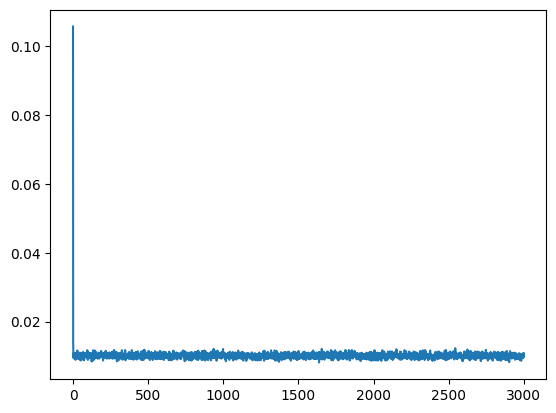

In [10]:
plt.plot(average_mrates[:5000])